In [1]:
%load_ext autoreload
%autoreload 2

import jax
import jax.numpy as jnp
import pandas as pd
import numpy as np
import tensorflow_probability.substrates.jax as tfp
import matplotlib.pyplot as plt
import arviz as az
import os
import pkg_resources

tfd = tfp.distributions
tfb = tfp.bijectors

from bayesianquilts.model import BayesianModel
from bayesianquilts.vi.minibatch import minibatch_fit_surrogate_posterior
from bayesianquilts.metrics.ais import AdaptiveImportanceSampler, PoissonRegressionLikelihood


/var/folders/9g/95lvk8690_52tvn55sr5m9nh0000gn/T/ipykernel_21749/2465634065.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Patched _JointDistributionNamedSpec with _structure_with_callables=None
TFP Specs patched successfully.


In [2]:
# Load the dataset
try:
    data_path = pkg_resources.resource_filename('bayesianquilts.data', 'roachdata.csv')
except ImportError:
    # Fallback if package not installed
    data_path = '../../bayesianquilts/data/roachdata.csv'
    if not os.path.exists(data_path):
        data_path = 'bayesianquilts/data/roachdata.csv'

print(f'Loading data from {data_path}')
df = pd.read_csv(data_path)
print(df.head())

# Preprocessing
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Target
y_data = df['y'].values

# Features
# Drop target and any index columns
X_df = df.drop(columns=['y'])
X_data = X_df.values.astype(np.float32)
y_data = y_data.astype(np.float32)

print(f'X shape: {X_data.shape}, y shape: {y_data.shape}')


Loading data from /Users/josh/workspace/bayesianquilts/bayesianquilts/data/roachdata.csv
   Unnamed: 0    y  roach1  treatment  senior  exposure2
0           1  153  308.00          1       0   0.800000
1           2  127  331.25          1       0   0.600000
2           3    7    1.67          1       0   1.000000
3           4    7    3.00          1       0   1.000000
4           5    0    2.00          1       0   1.142857
X shape: (262, 4), y shape: (262,)


In [3]:

import jax
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp
import tensorflow_probability.substrates.jax.distributions as tfd
from tensorflow_probability.substrates.jax import tf2jax as tf
from bayesianquilts.model import BayesianModel
# Try importing DenseHorseshoe from likely locations
try:
    from bayesianquilts.nn.dense import DenseHorseshoe
except ImportError:
    from bayesianquilts.predictors.nn.dense import DenseHorseshoe

class NeuralPoissonRegression(DenseHorseshoe):
    def __init__(
        self,
        dim_regressors: int,
        hidden_size: int = 6,
        depth: int = 2,
        dtype: tf.DType = jnp.float32,
        **kwargs
    ):
        # Architecture: input -> [hidden]*depth -> output (1)
        layer_sizes = [hidden_size] * depth + [1]
        
        super(NeuralPoissonRegression, self).__init__(
            input_size=dim_regressors,
            layer_sizes=layer_sizes,
            activation_fn=jax.nn.relu,
            weight_scale=1.0,
            bias_scale=1.0,
            dtype=dtype,
            **kwargs
        )
        self.input_dim = dim_regressors
        # Fix for DenseHorseshoe not setting var_list
        # We must use latent variable names from prior, NOT variational param names from params
        if hasattr(self, 'prior_distribution') and hasattr(self.prior_distribution, 'model'):
             self.var_list = list(self.prior_distribution.model.keys())
        elif hasattr(self, 'params') and self.params is not None:
             # Fallback, though likely incorrect for ADVI
             self.var_list = list(self.params.keys())


    def predictive_distribution(self, data: dict, **params):
        X = data["X"].astype(self.dtype)
        
        # Output of eval is (batch, 1) usually, or (samples, batch, 1)
        # We need to handle parameter sampling dimensions
        out = self.eval(X, params) # Shape: (..., batch_size, 1)
        
        # Squeeze the last dimension to get rate log-scale
        log_rate = jnp.squeeze(out, axis=-1) 
        rate = jnp.exp(log_rate)
        
        log_lik = None
        if 'y' in data:
            rv = tfd.Poisson(rate=rate)
            log_lik = rv.log_prob(data['y'])
            
        return {
            "prediction": rate,
            "log_likelihood": log_lik,
             "log_rate": log_rate
        }

    def log_likelihood(self, data, **params):
        return self.predictive_distribution(data, **params)["log_likelihood"]

    def unormalized_log_prob(self, data, prior_weight=1.0, **params):
        log_lik = self.log_likelihood(data, **params)
        prior = self.prior_distribution.log_prob(params)
        # Sum log_lik over data points?
        # log_lik shape: (S, N) or (N,)
        if log_lik.ndim > 1:
            total_ll = jnp.sum(log_lik, axis=-1)
        else:
            total_ll = jnp.sum(log_lik)
            
        return total_ll + prior * prior_weight


    # Wrapper for MCMC sampling to match PoissonRegression interface if needed
    # But DenseHorseshoe usually handles this via surrogate_distribution


In [3]:

from bayesianquilts.metrics.ais import LikelihoodFunction
import jax.flatten_util

class NeuralPoissonLikelihood(LikelihoodFunction):
    def __init__(self, model):
        self.model = model
        self.dtype = model.dtype

    def log_likelihood(self, data, params):
        # params might be (S, ...) or (S, N, ...) from AIS tiling
        # Check w_0 rank to detect if we have per-datum parameters
        # Standard MCMC: (S, D_in, H) -> Rank 3
        # AIS per-datum: (S, N, D_in, H) -> Rank 4
        
        w0 = params['w_0']
        if w0.ndim == 4:
             # Case: (S, N, D, H). We must map over N.
             X = data['X']
             y = data['y']
             
             def single_data_ll(x_i, y_i, params_i):
                 # params_i: (S, D, H)
                 d = {'X': x_i[None, :], 'y': y_i} 
                 ll = self.model.log_likelihood(d, **params_i)
                 return jnp.squeeze(ll)
             
             # Map over N (axis 0 of data, axis 1 of params)
             in_axes_params = jax.tree_util.tree_map(lambda x: 1, params)
             
             # Result: (N, S)
             ll_val = jax.vmap(single_data_ll, in_axes=(0, 0, in_axes_params))(X, y, params)
             return ll_val.T # (S, N)
        else:
             return self.model.log_likelihood(data, **params)

    def _flatten_params(self, params):
        flat_params, unflatten_fn = jax.flatten_util.ravel_pytree(params)
        return flat_params, unflatten_fn

    def log_likelihood_gradient(self, data, params):
        # We need gradient per sample per data point
        # But efficiently.
        # params structure: {'w_0': (S, D_in, D_out), ...}
        
        # Define single-sample, single-datum log likelihood function
        def single_log_lik(flat_p, x_single, y_single, unflatten_fn):
             # Placeholder
             pass
             
        # Strategy: Map over samples S. vmap over N
        
        # Get one sample to define structure
        one_sample_params = jax.tree_util.tree_map(lambda x: x[0], params)
        flat_proto, unflatten = jax.flatten_util.ravel_pytree(one_sample_params)
        
        # Flatten all samples: (S, K)
        flat_params_S = jax.vmap(lambda p: jax.flatten_util.ravel_pytree(p)[0])(params)
        
        X = data['X']
        y = data['y']
        
        def log_lik_fn(flat_theta, x, y):
            theta = unflatten(flat_theta)
            # theta values have no sample dim here
            # model.eval needs sample dim? 
            # NeuralPoissonRegression.eval expects standard arrays. 
            # If we pass single theta, it returns single output.
            
            # Construct data dict
            d = {'X': x[None, :], 'y': y} # Add batch dim
            
            # Call prediction: returns scalar log lik (since 1 data point)
            ll = self.model.log_likelihood(d, **theta)
            return jnp.squeeze(ll)

        # Grad w.r.t theta: (K,)
        grad_fn = jax.grad(log_lik_fn)
        
        # Vectorize over Data (N) and Samples (S)
        # We want (S, N, K)
        
        # vmap over N (data)
        # grad_fn(theta, x_n, y_n) -> (K,)
        grad_vmap_N = jax.vmap(grad_fn, in_axes=(None, 0, 0)) # -> (N, K)
        
        # vmap over S (samples)
        # grad_vmap_SN = jax.vmap(grad_vmap_N, in_axes=(0, None, None)) # -> (S, N, K)
        
        grads = jax.vmap(lambda p: grad_vmap_N(p, X, y))(flat_params_S)
        return grads

    def log_likelihood_hessian_diag(self, data, params):
        # Similar to gradient but Hessian diagonal
         # Get one sample to define structure
        one_sample_params = jax.tree_util.tree_map(lambda x: x[0], params)
        flat_proto, unflatten = jax.flatten_util.ravel_pytree(one_sample_params)
        
        # Flatten all samples: (S, K)
        flat_params_S = jax.vmap(lambda p: jax.flatten_util.ravel_pytree(p)[0])(params)
        
        X = data['X']
        y = data['y']
        
        def log_lik_fn(flat_theta, x, y):
            theta = unflatten(flat_theta)
            d = {'X': x[None, :], 'y': y}
            ll = self.model.log_likelihood(d, **theta)
            return jnp.squeeze(ll)
            
        def hess_diag_fn(flat_theta, x, y):
            # Hessian is (K, K). Diag is (K,)
            return jnp.diag(jax.hessian(log_lik_fn)(flat_theta, x, y))

        hess_diag_vmap_N = jax.vmap(hess_diag_fn, in_axes=(None, 0, 0)) # -> (N, K)
        hess_diag = jax.vmap(lambda p: hess_diag_vmap_N(p, X, y))(flat_params_S)
        
        return hess_diag

    def extract_parameters(self, params):
        # Flatten params: (S, K)
        flat_params = jax.vmap(lambda p: jax.flatten_util.ravel_pytree(p)[0])(params)
        return flat_params

    def reconstruct_parameters(self, flat_params, template):
        # Template is just used to get the unflatten function
        # We can assume template has the structure of one sample
        if isinstance(template['w_0'], jnp.ndarray) and template['w_0'].ndim > 2:
             # Template has sample dim? extract one
             template = jax.tree_util.tree_map(lambda x: x[0], template)
             
        dummy_flat, unflatten = jax.flatten_util.ravel_pytree(template)
        K = dummy_flat.shape[0]
        
        # Handle arbitrary batch dimensions
        input_shape = flat_params.shape
        # input_shape should be (..., K)
        
        if input_shape[-1] != K:
             raise ValueError(f"Last dimension of flat_params {input_shape} does not match K={K}")
             
        batch_dims = input_shape[:-1]
        n_batch = 1
        for d in batch_dims:
            n_batch *= d
            
        flat_reshaped = flat_params.reshape((n_batch, K))
        
        # vmap over the flattened batch
        unflattened_flat = jax.vmap(unflatten)(flat_reshaped)
        
        # Reshape each leaf back to (*batch_dims, *leaf_shape)
        def reshape_leaf(leaf):
             # leaf has shape (n_batch, ...)
             leaf_param_shape = leaf.shape[1:]
             return leaf.reshape(batch_dims + leaf_param_shape)
             
        return jax.tree_util.tree_map(reshape_leaf, unflattened_flat)



In [4]:

# Instantiate Neural Model
# 2 hidden layers of size 6
model = NeuralPoissonRegression(
    dim_regressors=X_data.shape[1],
    hidden_size=6,
    depth=2,
    dtype=jnp.float32  # Match data
)

# Data dictionary
data_dict = {'X': X_data, 'y': y_data}
data_jax = {'X': jnp.array(X_data), 'y': jnp.array(y_data)}

# Check init
print('Checking initialization...')
try:
    seed = jax.random.PRNGKey(42)
    # dense.py logic for params... 
    # model.params might differ.
    # DenseHorseshoe uses self.prior_distribution
    params = model.prior_distribution.sample(2, seed=seed)
    # Need to check structure of params?
    print('Initial sample keys:', params.keys())
    # print('Log prob check:', model.log_probs(data_dict, **params)) 
    # Note: NeuralPoissonRegression inherits DenseHorseshoe which does not implement log_probs usually (it has log_prob).
    # And we implemented log_likelihood.
    # Let's skip log_prob check or use the right method if needed.
except Exception as e:
    print(f'Initialization failed: {e}')

# Fit with MCMC (NUTS)
print('Fitting neural model with MCMC (NUTS)...')
try:
    # Use fit_mcmc for NUTS sampling
    model.fit_mcmc(
        data=data_dict,
        num_samples=2000,
        num_warmup=1000,
        num_chains=4,
        target_accept_prob=0.8
    )
    print("MCMC Fit Complete.")
except Exception as e:
    print(f"MCMC Fit failed: {e}")
    # Fallback or exit?


Checking initialization...
Log prob check: [           nan -1.6171574e+23]
Fitting model with MCMC (NUTS)...
Running NUTS with 4 chains...
  Warmup: 3000, Samples: 2000
  Target acceptance: 0.8, Max tree depth: 10

Chain 1/4:
  Running warmup and sampling...
  Acceptance ratio: 0.000

Chain 2/4:
  Running warmup and sampling...
  Acceptance ratio: 0.998

Chain 3/4:
  Running warmup and sampling...
  Acceptance ratio: 0.999

Chain 4/4:
  Running warmup and sampling...
  Acceptance ratio: 0.998

--- MCMC Complete ---
Mean acceptance ratio: 0.749
  beta: mean=[-0.04477079 -0.34137705 -0.30564195  0.11430446], std=[0.08884822 0.30035457 0.13116509 0.0865778 ], max_rhat=2206051.250
  intercept: mean=[2.2396662], std=[1.2597448], max_rhat=2043.766
Parameter Summary (details above):
  beta: mean=[-0.04477079 -0.34137705 -0.30564195  0.11430446], std=[0.08884822 0.30035457 0.13116509 0.0865778 ]
  intercept: mean=[2.2396662], std=[1.2597448]


In [ ]:
# Full Simulation for Table Metrics (Optimized for Memory)
import pandas as pd
from tqdm.auto import tqdm
import numpy as np
import copy
import gc

# Initialize Likelihood and Sampler
likelihood_fn = NeuralPoissonLikelihood(model)
ais_sampler = AdaptiveImportanceSampler(likelihood_fn=likelihood_fn)

n_simulations = 100
n_samples = 1000
rhos = [ 4**-r for r in range(-2, 11) ]

# Split transformations
base_transform = ['identity']
other_transforms = ['ll', 'kl', 'var', 'mm1', 'mm2', 'pmm1', 'pmm2']

print(f"Running {n_simulations} simulations with s={n_samples} samples per run.")
print(f"Rhos: {rhos}")
print(f"Base Transform: {base_transform}")
print(f"Other Transforms: {other_transforms}")

data_jax = {'X': jnp.array(X_data), 'y': jnp.array(y_data)}
N_obs = data_jax['y'].shape[0]

simulation_records = []

for i in tqdm(range(n_simulations), desc="Simulations"):
    # 1. Sample Parameters
    params = model.sample_mcmc(num_samples=n_samples)
    
    # 2. Run AIS with Identity FIRST
    results_base = ais_sampler.adaptive_is_loo(
        data=data_jax,
        params=params,
        rhos=rhos,
        variational=False, # MCMC samples
        transformations=base_transform
    )
    
    # Extract identity khat (convert to numpy for mutability)
    khat_identity = np.array(results_base['identity']['khat'])
    
    # Identify problematic points
    idx_bad = np.where(khat_identity >= 0.7)[0]
    
    print(f"Sim {i+1}: Found {len(idx_bad)} / {N_obs} data points needing adaptation.")
    
    # Clean up results_base immediately to free memory
    del results_base
    gc.collect()
    
    # Prepare storage for this simulation's khats per method
    # Initialize with identity khat for all (Hybrid approach: default to identity)
    method_khats = {}
    method_khats['identity'] = khat_identity
    for m in other_transforms:
        method_khats[m] = np.array(khat_identity.copy())
        
    # 3. Process problematic points with other methods
    if len(idx_bad) > 0:
        batch_size = 64
        num_batches = int(np.ceil(len(idx_bad) / batch_size))
        
        for b in range(num_batches):
            batch_idx = idx_bad[b*batch_size : (b+1)*batch_size]
            
            # Create data subset for BAD points in this batch
            # JAX arrays can be indexed by numpy arrays
            data_subset = {
                'X': data_jax['X'][batch_idx],
                'y': data_jax['y'][batch_idx]
            }
            
            # Run AIS on subset
            results_subset = ais_sampler.adaptive_is_loo(
                data=data_subset,
                params=params,
                rhos=rhos,
                variational=False,
                transformations=other_transforms
            )
            
            # Update method stats
            for base_method in other_transforms:
                # Find best khat for this base method (across rhos)
                khat_arrays = []
                for key, res in results_subset.items():
                    if key == 'best': continue
                    if key == base_method or key.startswith(base_method + '_'):
                        khat_arrays.append(res['khat'])
                
                if khat_arrays:
                    # Min over rhos for this method on the SUBSET
                    min_khat_subset = np.array(np.min(np.stack(khat_arrays), axis=0))
                    
                    # Update the main array at the bad indices for this batch
                    method_khats[base_method][batch_idx] = min_khat_subset
                    
            # Clean up batch results
            del results_subset
            gc.collect()

    # Define Groups
    groups = {
        'Base': ['identity'],
        'PMM1': ['pmm1'],
        'PMM2': ['pmm2'],
        'KL': ['kl'],
        'Var': ['var'],
        'Ours_Combined': ['pmm1', 'pmm2', 'kl', 'var'],
        'LL': ['ll'],
        'MM1': ['mm1'],
        'MM2': ['mm2'],
        'Full': other_transforms + base_transform
    }
    
    sim_counts = {}
    for group_name, methods in groups.items():
        grouped_khats = []
        for m in methods:
             if m in method_khats:
                 grouped_khats.append(method_khats[m])
        
        if grouped_khats:
            # Best khat across ANY method in the group for each obs
            best_group_khat = np.min(np.stack(grouped_khats), axis=0)
            # Count FAILURES (khat > 0.7)
            n_failures = np.sum(best_group_khat > 0.7)
            sim_counts[group_name] = n_failures
        else:
            sim_counts[group_name] = np.nan
            
    simulation_records.append(sim_counts)

# 4. Aggregate Statistics across simulations
df_sims = pd.DataFrame(simulation_records)
stats = df_sims.agg(['mean', 'std'])

print("\n--- Table Metrics: Unsuccessful Adaptations (Roaches/PR) ---")
print(stats.round(1))

# Optional: Format for LaTeX
print("\nLaTeX Format (Mean \pm Std):")
for col in df_sims.columns:
    m = stats.loc['mean', col]
    s = stats.loc['std', col]
    print(f"{col}: {m:.1f} \pm {s:.1f}")


Running 100 simulations with s=1000 samples per run.
Rhos: [1, 0.25, 0.0625, 0.015625, 0.00390625, 0.0009765625, 0.000244140625, 6.103515625e-05, 1.52587890625e-05, 3.814697265625e-06, 9.5367431640625e-07]
Transformations: ['identity', 'll', 'kl', 'var', 'mm1', 'mm2', 'pmm1', 'pmm2']


Simulations:   0%|          | 0/100 [00:00<?, ?it/s]

Comparing khat across methods...
Min khat per data point (min/max): -1.575/inf


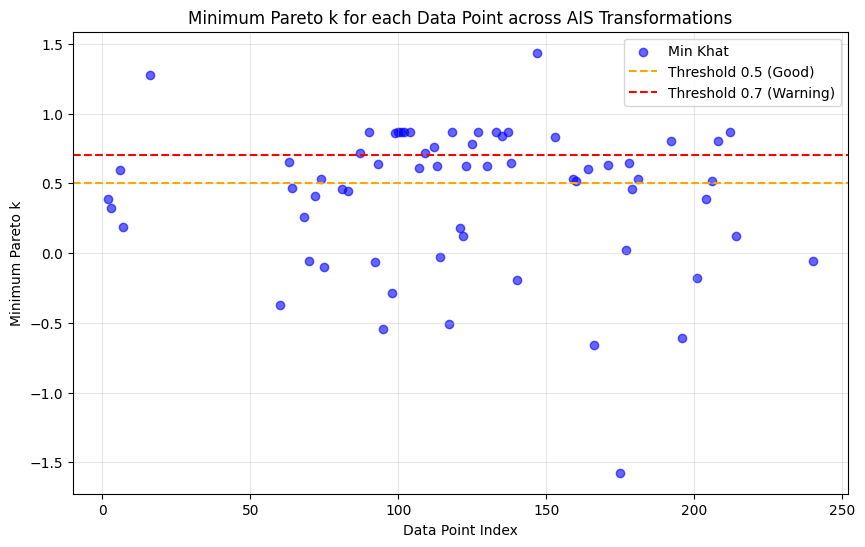

In [ ]:
# Compare khat across methods
print('Comparing khat across methods...')
khats = []
method_names = []
for method, k_vals in method_khats.items():
    khats.append(k_vals)
    method_names.append(method)

khats = np.array(khats) # Shape: (n_methods, n_data)
min_khats = np.min(khats, axis=0)

# We don't have all methods' full khats for all points (only identity/bad points updated),
# but method_khats holds the "effective" khat per method (identity fallback).
# Actually method_khats has [observations] size for each method.

print(f'Min khat per data point (min/max): {min_khats.min():.3f}/{min_khats.max():.3f}')

# Create a scatter plot of min khat
plt.figure(figsize=(10, 6))
plt.scatter(range(len(min_khats)), min_khats, c='blue', alpha=0.6, label='Min Khat')
plt.axhline(y=0.5, color='orange', linestyle='--', label='Threshold 0.5 (Good)')
plt.axhline(y=0.7, color='red', linestyle='--', label='Threshold 0.7 (Warning)')
plt.xlabel('Data Point Index')
plt.ylabel('Minimum Pareto k')
plt.title('Minimum Pareto k for each Data Point across AIS Transformations')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


Found 218 points with identity khat >= 0.7


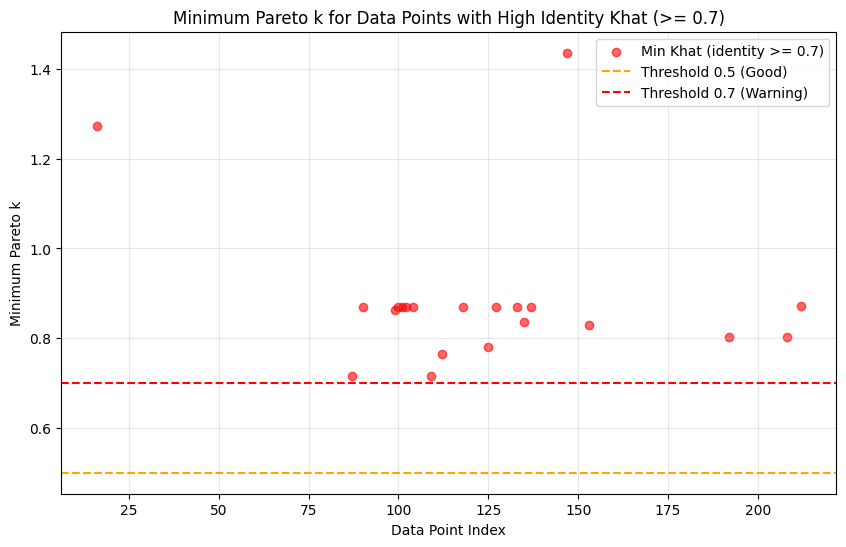

In [ ]:
# Conditional plot: Min khat where identity khat >= 0.7
if 'identity' in method_khats:
    identity_khat = method_khats['identity']
    # Filter indices
    high_khat_indices = np.where(identity_khat >= 0.7)[0]
    
    if len(high_khat_indices) > 0:
        print(f"Found {len(high_khat_indices)} points with identity khat >= 0.7")
        min_khats_filtered = min_khats[high_khat_indices]
        
        plt.figure(figsize=(10, 6))
        plt.scatter(high_khat_indices, min_khats_filtered, c='red', alpha=0.6, label='Min Khat (identity >= 0.7)')
        plt.axhline(y=0.5, color='orange', linestyle='--', label='Threshold 0.5 (Good)')
        plt.axhline(y=0.7, color='red', linestyle='--', label='Threshold 0.7 (Warning)')
        plt.xlabel('Data Point Index')
        plt.ylabel('Minimum Pareto k')
        plt.title('Minimum Pareto k for Data Points with High Identity Khat (>= 0.7)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print("No points found with identity khat >= 0.7")
